In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
df = pd.read_csv("advertising.csv", engine="python")  
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [5]:
df.shape

(200, 4)

In [6]:
def manual_correlation(x, y):
    return np.corrcoef(x, y)[0, 1]

print("📊 Manual Pearson Correlation with 'Sales':")
for feature in ['TV', 'Radio', 'Newspaper']:
    corr = manual_correlation(df[feature], df['Sales'])
    print(f"{feature} ↔ Sales: {corr:.4f}")


📊 Manual Pearson Correlation with 'Sales':
TV ↔ Sales: 0.9012
Radio ↔ Sales: 0.3496
Newspaper ↔ Sales: 0.1580


# preprocessing

In [7]:
X_raw = df[['TV', 'Radio', 'Newspaper']].values
y = df['Sales'].values.reshape(-1, 1) 
n_samples = X_raw.shape[0]

In [8]:

X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0)
X_std[X_std == 0] = 1 

X_scaled = (X_raw - X_mean) / X_std
X = np.hstack((np.ones((n_samples, 1)), X_scaled)) 

# PCA functions

In [33]:
def pca_reconstruction_error(X, ks):

    mu = X.mean(axis=0)
    A = X - mu

    ATA = A.T @ A

    eigvals, eigvecs = np.linalg.eigh(ATA)

    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    errors = []
    for k in ks:

        Ek = eigvecs[:, :k]
        
        # Step 5: Project & reconstruct
        W = A @ Ek         # projections
        L = W @ Ek.T       # linear combinations
        R = L + mu         # reconstructed points
        
        # Step 6: Compute error
        err = np.sum((X - R)**2)
        errors.append((k, err))
    
    return pd.DataFrame(errors, columns=["k", "reconstruction_error"])


In [38]:
# redusing dimantions by pca
def PCA(X,k):

    mu = X.mean(axis=0)
    A = X - mu

    ATA = A.T @ A
    
    eigvals, eigvecs = np.linalg.eigh(ATA)
    
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    Ek = eigvecs[:, :k]
       
    W =A @ Ek  
    L = W @ Ek.T
    R = L + mu 

    return W,R

Housing Reconstruction Errors:
     k  reconstruction_error
0   1          3.258295e+02
1   2          1.291783e+02
2   3          6.706258e-30
3   5          6.706258e-30
4   7          6.706258e-30
5  10          6.706258e-30
6  12          6.706258e-30


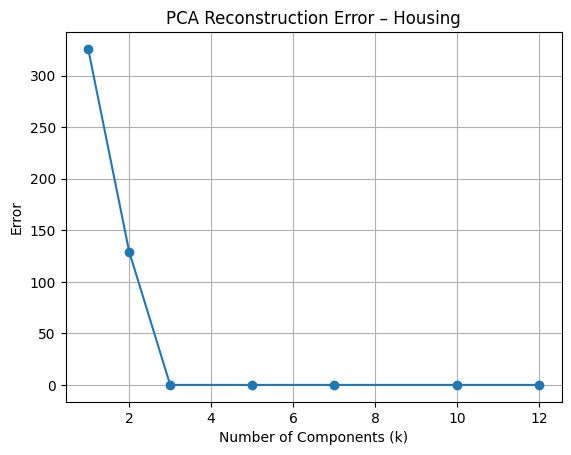

In [10]:


ks = [1,2,3,5,7,10,12]   
house_res = pca_reconstruction_error(X, ks)
print("Housing Reconstruction Errors:\n", house_res)

plt.plot(house_res["k"], house_res["reconstruction_error"], marker="o")
plt.title("PCA Reconstruction Error – Housing")
plt.xlabel("Number of Components (k)")
plt.ylabel("Error")
plt.grid(True)
plt.show()


# ploting data into PCA 

In [ ]:

projections,_=PCA(X,2)
projections_3D,_=PCA(X,3)
projections
PCA_1_2D=projections[0]
PCA_2_2D=projections[1]

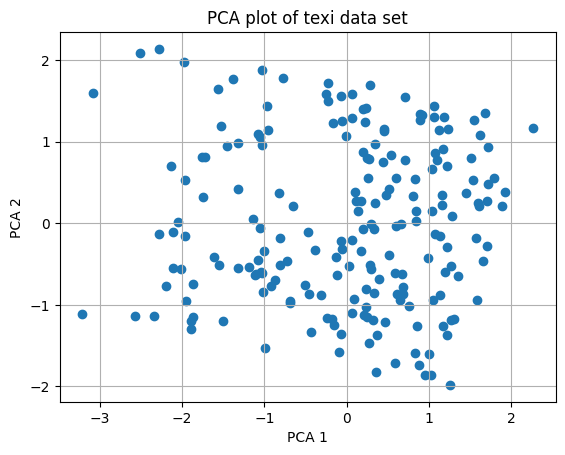

In [13]:


plt.scatter(PCA_1_2D,PCA_2_2D)
plt.title("PCA plot of texi data set")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

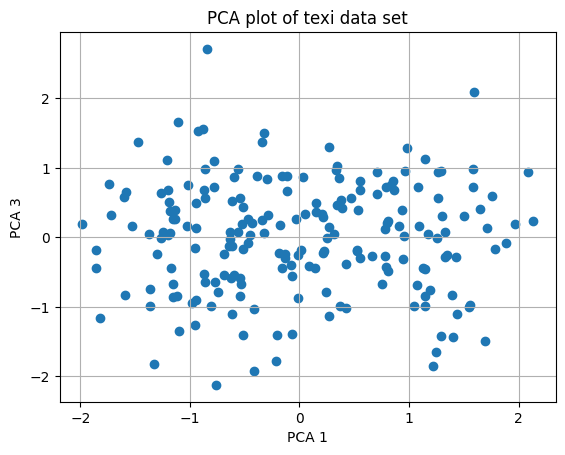

In [14]:

plt.scatter(projections_3D[1],projections_3D[2])
plt.title("PCA plot of texi data set")
plt.xlabel("PCA 1")
plt.ylabel("PCA 3")
plt.grid(True)
plt.show()

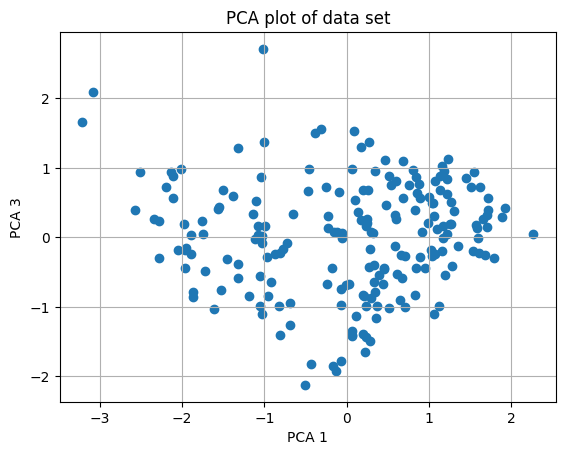

In [15]:

plt.scatter(projections_3D[0],projections_3D[2])
plt.title("PCA plot of data set")
plt.xlabel("PCA 1")
plt.ylabel("PCA 3")
plt.grid(True)
plt.show()

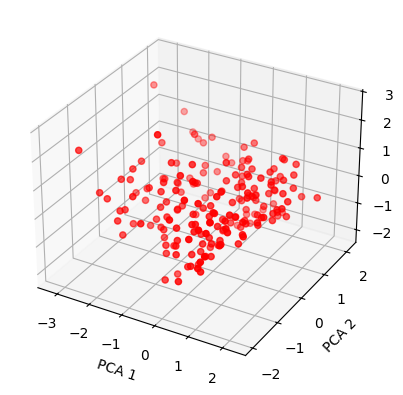

In [16]:
projections_3D
PCA_1_3D=projections_3D[0]
PCA_2_3D=projections_3D[1]
PCA_3_3D=projections_3D[2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projections_3D[0], projections_3D[1], projections_3D[2], c='r', marker='o')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

In [17]:
fig = px.scatter_3d(projections_3D.T, x=0, y=1, z=2,size_max=5000)
fig.update_layout(
    title='My 3D Scatter Plot',
    scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3'
    )
)
# Show plot
fig.show()

#  seeing diffrence in model  with and without PCA

## modle

In [18]:
def linear(X, y, alpha=0.01, epochs=1000):
    n_samples = X.shape[0]
    w = np.zeros((X.shape[1], 1))
    loss_history = []

    for epoch in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        loss = (1 / (2 * n_samples)) * np.sum(error ** 2)
        loss_history.append(loss)

        gradient = (1 / n_samples) * (X.T @ error)
        w -= alpha * gradient

    return w, loss_history


In [61]:
w_withoutPCA,loss_withoutPCA=linear(X, y, alpha=0.01, epochs=1000)

In [64]:
k=[1,2]

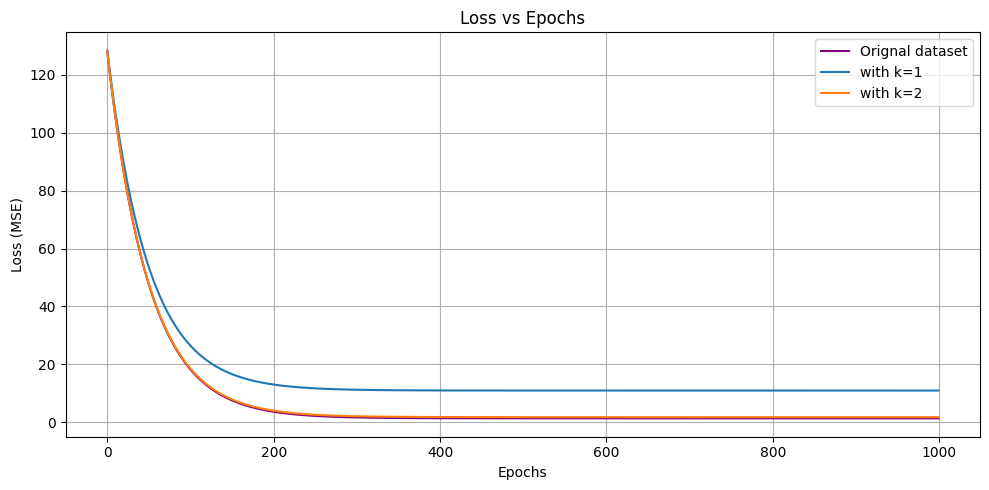

In [66]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(loss_withoutPCA)), y=loss_withoutPCA, label="Orignal dataset", color='purple')

for i in k:
    _,X_reconstructed=PCA(X,i)
    w_withPCA,loss_withPCA=linear(X_reconstructed, y, alpha=0.01, epochs=1000)
    sns.lineplot(x=range(len(loss_withPCA)), y=loss_withPCA, label=f"with k={i}")

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()